<a href="https://colab.research.google.com/github/thofes/judging_SJ_BA/blob/main/Mark7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Connect GDrive
from google.colab import drive
drive.mount('/content.gdrive')

#init Repository - YOLOv5
%cd /content


!git clone https://github.com/thofes/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install


#init Repository - OpenPose
import os
from os.path import exists, join, basename, splitext

#Change the drive to my mounted gdrive
%cd /content

git_repo_url = 'https://github.com/thofes/openpose'
project_name = splitext(basename(git_repo_url))[0]

if 1 or not exists(project_name):
  !rm -rf openpose
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  print("install new CMake becaue of CUDA10")
  cmake_version = 'cmake-3.20.2-linux-x86_64.tar.gz'
  if not exists(cmake_version):
    !wget -q 'https://cmake.org/files/v3.20/{cmake_version}'
  !tar xfz {cmake_version} --strip-components=1 -C /usr/local

  print("clone openpose")
  !git clone -q --depth 1 $git_repo_url
  print("install system dependencies")
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  print("build openpose")
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

In [ ]:
import os
from os.path import exists, join, basename, splitext
import json
import numpy as np



json_path = "/content.gdrive/My Drive//Train/data.json"
#json_path = "/content/data.json"
# dictionary to store mapping, labels, and Keypoints
data = {
    "labels":[],
    "keypoints":[]
}

PATH = "/content.gdrive/My Drive/Train"
label= []
try:
    label = next(os.walk(PATH))[1]
except StopIteration:
    pass
#data["labels"].append(label)
print(label)

for l in label:
  Path_jumpers = PATH + '/' + l
  print(Path_jumpers)
  Jumpers = []
  try:
    Jumpers = next(os.walk(Path_jumpers))[1]
  except StopIteration:
    pass
  print(Jumpers)

  for j in Jumpers:
    Path_Pic = Path_jumpers + '/' + j
    print(Path_Pic)

    %cd /content/yolov5
    !python detect.py --save-crop --source '{Path_Pic}' --project '{Path_Pic}' --save-txt

    folder_dir = Path_Pic + '/exp'
    %cd /content/openpose/build/examples/tutorial_api_python
    !python3 04_keypoints_from_images.py --image_dir '{folder_dir}' --keypoint_scale 3 --no_display true

    with open(Path_Pic + '/exp/keypoints.json', "r") as fp:
        keypoints_json = json.load(fp)

    data["keypoints"].append(keypoints_json)

    if l == 'NoTelemark':
        data["labels"].append(0)
    if l == 'Telemark':
        data["labels"].append(1)    

    #with open(Path_Pic + '/exp/keypoints.txt', "r") as keypointfile:
        #keypoints = keypointfile.read()
    #data["keypoints"].append(keypoints)


with open(json_path, "w") as fp:
  json.dump(data, fp, indent=4)


[0.69563919 0.33112499 0.19972943 ... 0.24973664 0.6155839  0.3830581 ]
(49, 1575)
1
(49,)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 525)               827400    
                                                                 
 dense_61 (Dense)            (None, 175)               92050     
                                                                 
 dense_62 (Dense)            (None, 35)                6160      
                                                                 
 dense_63 (Dense)            (None, 1)                 36        
                                                                 
Total params: 925,646
Trainable params: 925,646
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 221ms/step - loss: 0.7235 - accurac

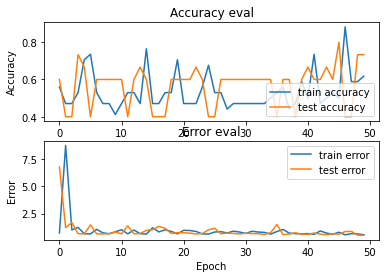

In [60]:

#test load data
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


with open('/content.gdrive/MyDrive/Train/data.json', "r") as fp:
    data = json.load(fp)

# convert lists to numpy arrays
X = np.array(data["keypoints"])
#X = np.array(data["mfcc"])
y = np.array(data["labels"])

print(X[0])
print(X.shape)
print(y[0])
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


model = keras.Sequential()

model.add(keras.layers.Dense(525, input_dim = 1575, activation = 'relu'))

model.add(keras.layers.Dense(175, activation = 'relu'))

model.add(keras.layers.Dense(35, activation = 'relu'))

model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])


    # train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)
#model.fit(x = X_train, y = y_train, epochs = 256, verbose = 1)

    # plot accuracy and error as a function of the epochs
plot_history(history)

In [61]:
prediction = model.predict(X_test)
print(prediction.round())
print(y_test)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]
[1 0 0 0 0 0 1 0 1 0 0 1 0 1 1]


In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

my_accuracy = accuracy_score(y_test, prediction.round())
print(my_accuracy)

#baseline accuracy (was wäre wenn das System nur 1 prediction würde)
#summe der 1er in y / gesamtanzahl 
#accuracy des modells muss höher sein

precision = precision_score(y_test,prediction.round())
print(precision)






0.7333333333333333
1.0


In [ ]:
#Anpassung Musik

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content.gdrive/MyDrive/Train/data.json"




def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["keypoints"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    #axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    #axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    #axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    #axs[1].set_title("Error eval")

    plt.show()


if __name__ == "__main__":

    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # build network topology
    model = keras.Sequential()

    model.add(keras.layers.Dense(525, input_dim = 1575, activation = 'relu'))

    model.add(keras.layers.Dense(175, activation = 'relu'))

    model.add(keras.layers.Dense(35, activation = 'relu'))

    model.add(keras.layers.Dense(1, activation = 'sigmoid'))

    # compile model
    model.summary()

    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

    # train model
    history = model.fit(x = X_train, y = y_train, epochs = 256, verbose = 1)

    # plot accuracy and error as a function of the epochs
    plot_history(history)